In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Bell_Amundsen_Extent = pd.read_excel(filepath, sheet_name='Bell-Amundsen-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Bell_Amundsen_Extent)
fp.date_time(Bell_Amundsen_Extent)

,Extent,Date
0,1179855.894,1979-01-01
1,879585.254,1979-02-01
2,791619.096,1979-03-01
3,1254912.071,1979-04-01
4,1620142.247,1979-05-01
...,...,...
533,1556568.455,2023-06-01
534,1917507.979,2023-07-01
535,2601630.327,2023-08-01
536,2534223.780,2023-09-01


In [5]:
scaler = MinMaxScaler()
Bell_Amundsen_Extent['Extent'] = scaler.fit_transform(Bell_Amundsen_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 8
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Bell_Amundsen_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((519, 12, 1), (519,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Bell_Amund_model_LT8/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 14s 179ms/step - loss: 0.2299 - root_mean_squared_error: 0.4795 - val_loss: 0.1992 - val_root_mean_squared_error: 0.4463
Epoch 2/50
53/53 [==============================] - 8s 157ms/step - loss: 0.1071 - root_mean_squared_error: 0.3273 - val_loss: 0.0799 - val_root_mean_squared_error: 0.2826
Epoch 3/50
53/53 [==============================] - 7s 130ms/step - loss: 0.0620 - root_mean_squared_error: 0.2489 - val_loss: 0.0758 - val_root_mean_squared_error: 0.2754
Epoch 4/50
53/53 [==============================] - 8s 150ms/step - loss: 0.0564 - root_mean_squared_error: 0.2374 - val_loss: 0.0672 - val_root_mean_squared_error: 0.2592
Epoch 5/50
53/53 [==============================] - 7s 140ms/step - loss: 0.0528 - root_mean_squared_error: 0.2298 - val_loss: 0.0605 - val_root_mean_squared_error: 0.2459
Epoch 6/50
53/53 [==============================] - 7s 132ms/step - loss: 0.0465 - root_mean_squared_error: 0.2156 - val_loss: 0.0515 - val

Epoch 33/50
53/53 [==============================] - 9s 170ms/step - loss: 0.0095 - root_mean_squared_error: 0.0975 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1006
Epoch 34/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0101 - root_mean_squared_error: 0.1006 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1007
Epoch 35/50
53/53 [==============================] - 2s 28ms/step - loss: 0.0103 - root_mean_squared_error: 0.1016 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1054
Epoch 36/50
53/53 [==============================] - 1s 27ms/step - loss: 0.0097 - root_mean_squared_error: 0.0985 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1012
Epoch 37/50
53/53 [==============================] - 1s 28ms/step - loss: 0.0096 - root_mean_squared_error: 0.0980 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1046
Epoch 38/50
53/53 [==============================] - 1s 25ms/step - loss: 0.0100 - root_mean_squared_error: 0.1000 - val_loss: 0.0104 - val

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

3.2670026580492655 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

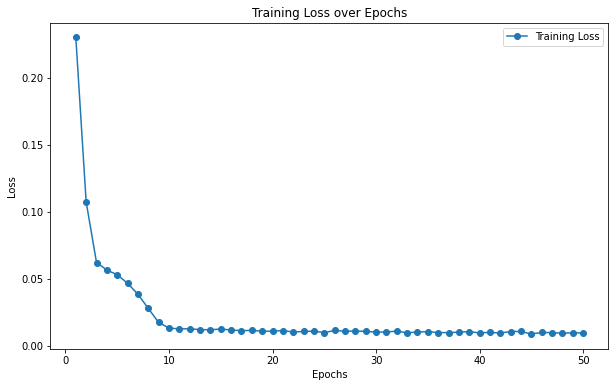

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

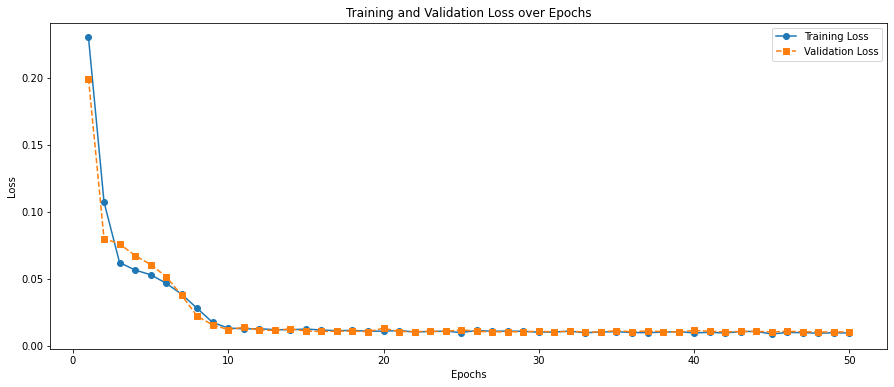

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Bell_Amund_model_LT8/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 11ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.09721849530868228
MAE : 0.0777337610460444


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,1.067769e+06,1202791.069
1,7.244244e+05,752834.272
2,5.437071e+05,451914.219
3,4.755287e+05,439855.813
4,7.036960e+05,807857.307
5,1.163029e+06,1184280.145
6,1.594757e+06,1468308.405
7,1.990458e+06,1540851.607
8,2.202377e+06,1989099.836
9,2.177428e+06,2096990.761


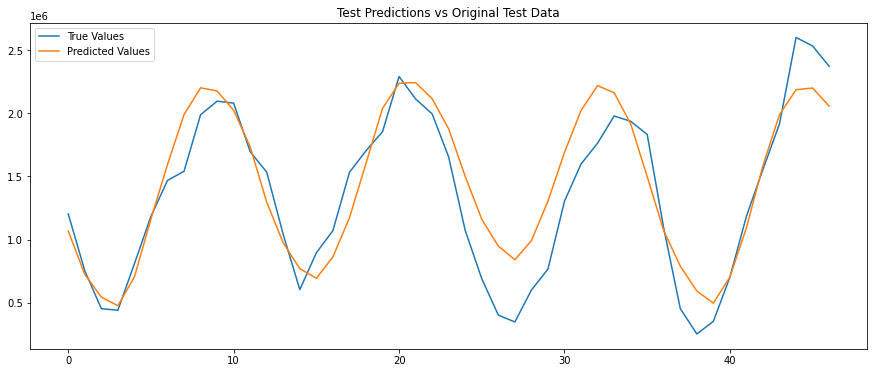

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 12ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

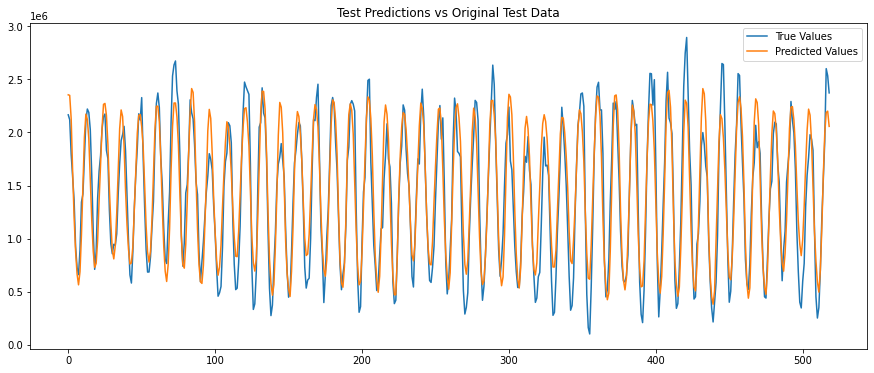

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()